In [1]:
import PIL
import numpy as np
import requests

def get_processed_img(url):
    # Open the image using the URL
    img_from_url = PIL.Image.open(requests.get(url, stream=True).raw)
    
    # Adjust the image dimensions to a standard size.
    new_image = img_from_url.resize((224, 224))
    
    # Transform the image into a NumPy array.
    processed_image = np.asarray(new_image)
    
    # Normalise pixel values if necessary
    if processed_image.max() > 1:
        processed_image = processed_image / 255
    
    # Add a batch dimension
    image = np.expand_dims(processed_image, axis=0)
    
    return image

In [2]:
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a sub-model that outputs the feature maps and final prediction
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Use GradientTape to record gradients
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        
        # If pred_index is not specified, use the predicted class index
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Calculate gradients
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Compute the heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalise the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm

def display_gradcam(img, heatmap, alpha=0.4):
    # Rescale heatmap to a range of 0-255
    heatmap = np.uint8(255 * heatmap)
    
    # Use the "jet" colormap to colourize the heatmap
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    # Transform the heatmap into an image.
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    
    # Resize the heatmap to match the image dimensions
    jet_heatmap = jet_heatmap.resize((img.shape[2], img.shape[1]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)
    
    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img
    plt.imshow(superimposed_img[0])

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import layers

# Load DenseNet201 model with local weights
weights_path = '/Users/faizahkureshi/Desktop/Capstone Project/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5'
densenet_model = DenseNet201(weights=weights_path, include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the pre-trained model
for layer in densenet_model.layers:
    layer.trainable = False

# Add custom layers on top of the pre-trained model
flattened_layer = layers.Flatten()(densenet_model.output)
output_layer = layers.Dense(10, activation='softmax')(flattened_layer)

# Create the final model
final_model = tf.keras.models.Model(inputs=densenet_model.input, outputs=output_layer)


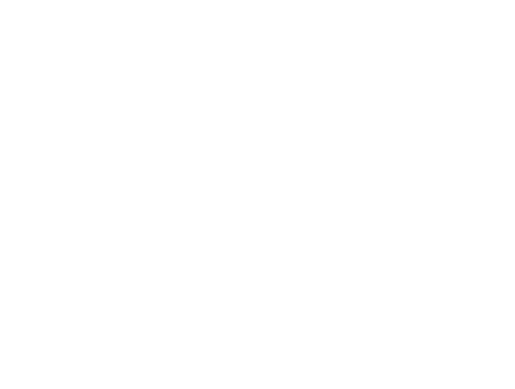

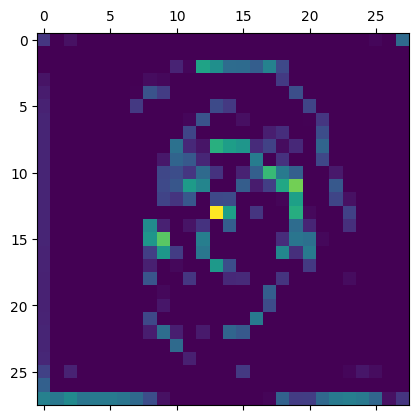

In [11]:
img_arr = get_processed_img('https://t3.ftcdn.net/jpg/01/05/57/38/360_F_105573812_cvD4P5jo6tMPhZULX324qUYFbNpXlisD.jpg')

heatmap = make_gradcam_heatmap(img_arr, final_model, 'conv3_block8_2_conv')

plt.axis('off')
plt.matshow(heatmap)
plt.show()

/var/folders/7t/xv0_sq952g3_jxbv3jltr8b00000gn/T/ipykernel_11569/879704149.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


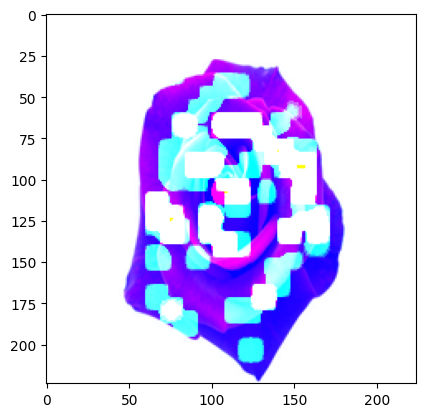

In [10]:
display_gradcam(get_processed_img('https://t3.ftcdn.net/jpg/01/05/57/38/360_F_105573812_cvD4P5jo6tMPhZULX324qUYFbNpXlisD.jpg'), heatmap)